In [35]:
import numpy as np
import scipy
from scipy import signal, optimize, io
import pandas as pd

import warnings

from matplotlib import pyplot as plt
import seaborn as sns

import utility
from utility import A2db, P2db, db2A, db2P

import adaptation
from mapping import qam_sym2iq_map, qam_mapping, qam_demapping, qam_order2bits, qam_simmetry_bits, qam_vh_bits, gray_code, qam16_ser_labeled, qam16_demap2bits_labeled,qam16_demap_labeled

In [36]:
mat_data = io.loadmat('pbm_test.mat')
skip_data_sym = 1000
tx_bits = mat_data['srcPermBitData'][4*skip_data_sym:-4*skip_data_sym, :]
tx_iq = mat_data['srcSymData'][skip_data_sym:-skip_data_sym, :].astype(dtype=complex)
rx_iq = mat_data['eqSymOutData'][skip_data_sym:-skip_data_sym, :].astype(dtype=complex)

In [37]:
print("initial data results:")
print("NMSE: {} dB".format(utility.nmse_db(tx_iq, rx_iq)))
ser0 = qam16_ser_labeled(rx_iq[:, 0], tx_iq[:, 0])
ser1 = qam16_ser_labeled(rx_iq[:, 1], tx_iq[:, 1])

rx_bits = np.zeros_like(tx_bits)
rx_bits[:, 0] = qam16_demap2bits_labeled(rx_iq[:, 0], tx_iq[:,0], tx_bits[:, 0])
rx_bits[:, 1] = qam16_demap2bits_labeled(rx_iq[:, 1], tx_iq[:,1], tx_bits[:, 1])
ber0 = np.mean(rx_bits[:, 0] ^ tx_bits[:, 0])
ber1 = np.mean(rx_bits[:, 1] ^ tx_bits[:, 1])

print("\tSER0: {}".format(ser0))
print("\tSER1: {}".format(ser1))
print("\tSER_AVG: {}".format(np.mean([ser0, ser1])))
print("\tBER0: {}".format(ber0))
print("\tBER1: {}".format(ber1))
print("\tBER_AVG: {}".format(np.mean([ber0, ber1])))


NMSE: -12.845170797882922 dB
initial data results:
	SER0: 0.030423383332296012
	SER1: 0.03225166490321778
	SER_AVG: 0.03133752411775689
	BER0: 0.00768170006846331
	BER1: 0.008175725088691107
	BER_AVG: 0.007928712578577208


In [27]:
M_range = np.arange(0, 15, 2)
NMSE_res = np.zeros((M_range.size, 3))
SER_res = np.zeros((M_range.size, 3))
BER_res = np.zeros((M_range.size, 3))

for i, M in enumerate(M_range):
    tx_iq_out, tx_bits_out, rx_iq_out, V, c = adaptation.LS_adapt(M, tx_iq, rx_iq, tx_bits)
    
    NMSE_res[i, 0] = utility.nmse_db(tx_iq_out[:, 0], rx_iq_out[:, 0])
    NMSE_res[i, 1] = utility.nmse_db(tx_iq_out[:, 1], rx_iq_out[:, 1])
    NMSE_res[i, 2] = utility.nmse_db(tx_iq_out, rx_iq_out)
    
    SER_res[i, 0] = qam16_ser_labeled(rx_iq_out[:, 0], tx_iq_out[:, 0])
    SER_res[i, 1] = qam16_ser_labeled(rx_iq_out[:, 1], tx_iq_out[:, 1])
    SER_res[i, 2] = np.mean((SER_res[i, 0], SER_res[i, 1]))
        
    rx_bits = np.zeros_like(tx_bits_out)
    rx_bits[:, 0] = qam16_demap2bits_labeled(rx_iq_out[:, 0], tx_iq_out[:,0], tx_bits_out[:, 0])
    rx_bits[:, 1] = qam16_demap2bits_labeled(rx_iq_out[:, 1], tx_iq_out[:,1], tx_bits_out[:, 1])
    BER_res[i, 0] = np.mean(rx_bits[:, 0] ^ tx_bits_out[:, 0])
    BER_res[i, 1] = np.mean(rx_bits[:, 1] ^ tx_bits_out[:, 1]) 
    BER_res[i, 2] = np.mean((BER_res[i, 0], BER_res[i, 1]))
    print('done {}/{}'.format(i+1, M_range.size))

done 1/8
done 2/8
done 3/8
done 4/8
done 5/8
done 6/8
done 7/8


MemoryError: Unable to allocate 6.44 GiB for an array with shape (1682, 257016) and data type complex128

<IPython.core.display.Javascript object>


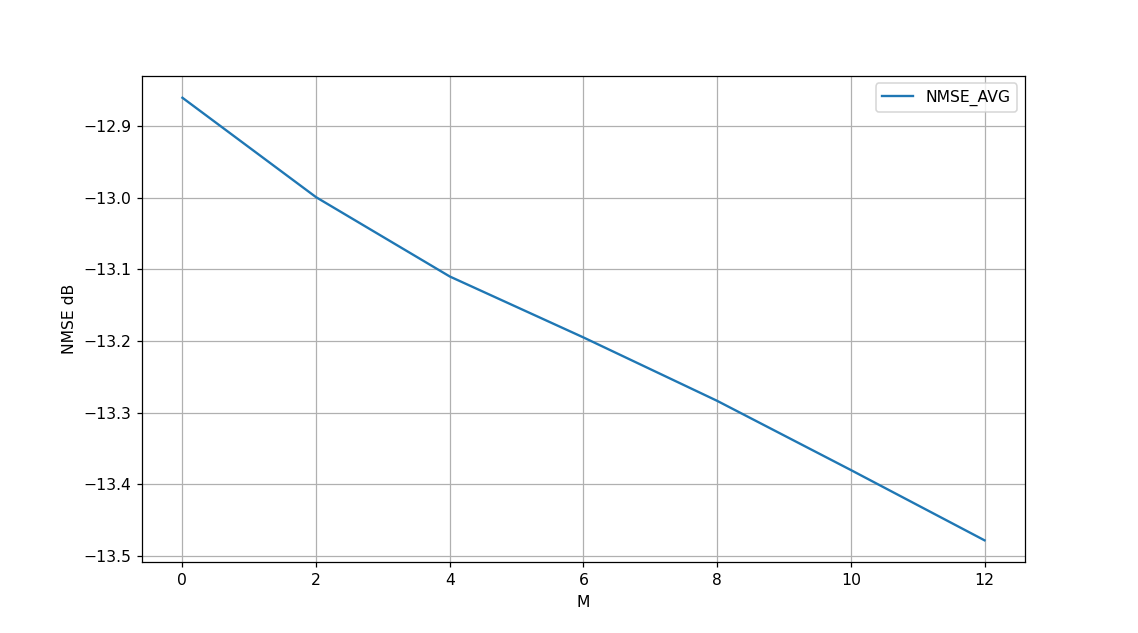

<IPython.core.display.Javascript object>


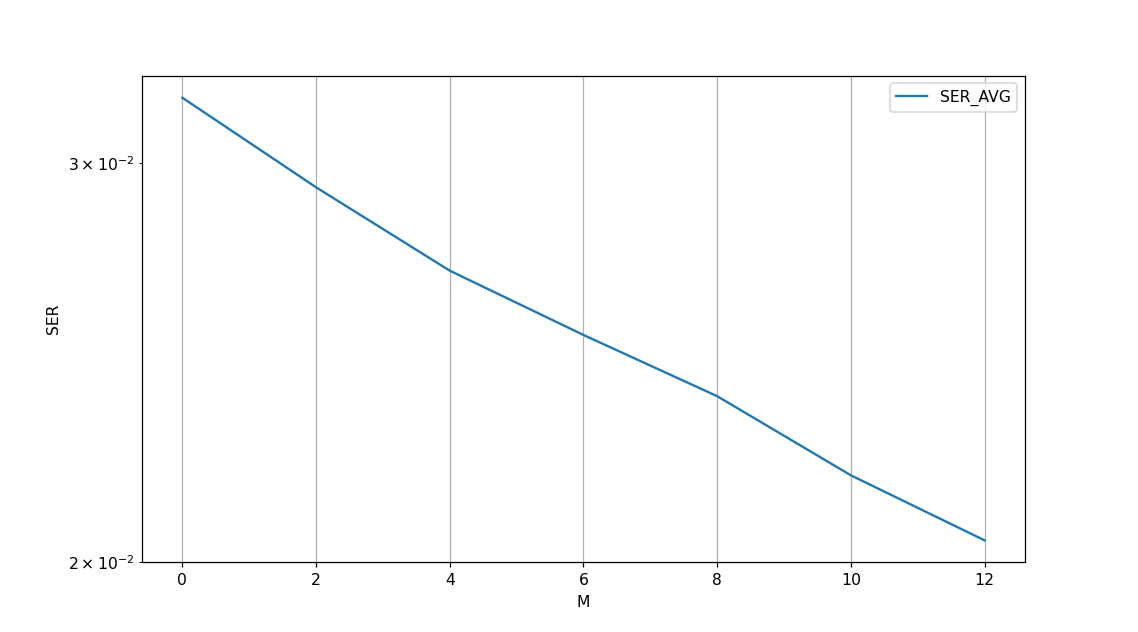

<IPython.core.display.Javascript object>


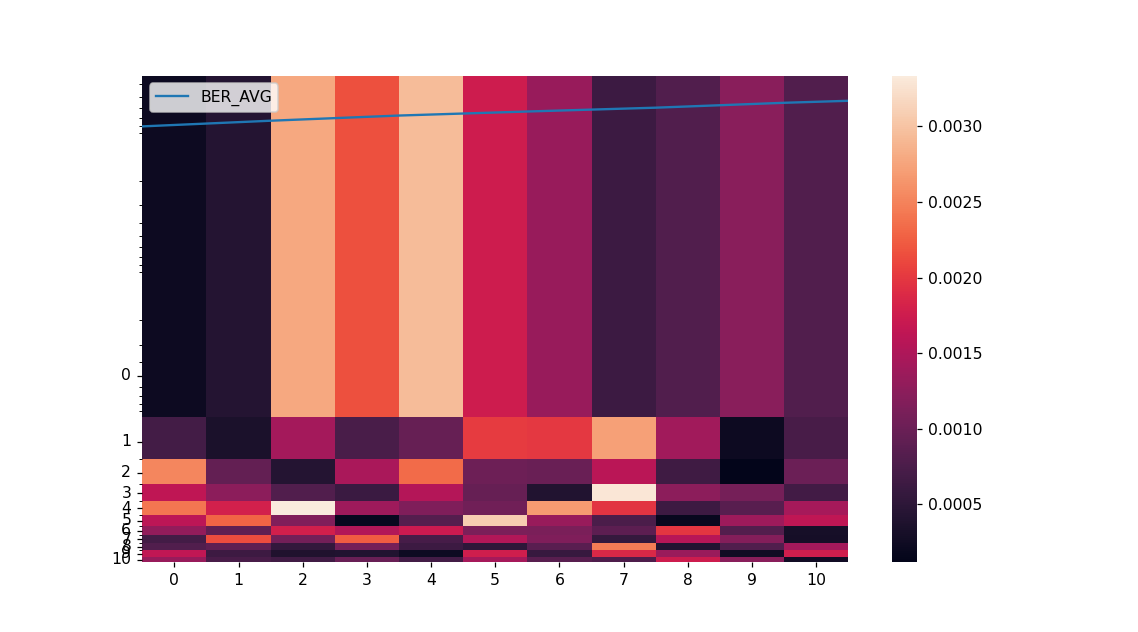

In [34]:
%matplotlib notebook

fig = plt.figure(figsize=(9, 5))
#plt.plot(M_range, NMSE_res, label=['NMSE_0', 'NMSE_1', 'NMSE_AVG'])
plt.plot(M_range, NMSE_res[:, 2], label='NMSE_AVG')
plt.xlabel('M')
plt.ylabel('NMSE dB')
plt.legend()
plt.grid(True)

fig = plt.figure(figsize=(9, 5))
#plt.semilogy(M_range, SER_res, label=['SER_0', 'SER_1', 'SER_AVG'])
plt.semilogy(M_range, SER_res[:, 2], label='SER_AVG')
plt.xlabel('M')
plt.ylabel('SER')
plt.legend()
plt.grid(True)

fig = plt.figure(figsize=(9, 5))
#plt.semilogy(M_range, BER_res, label=['BER_0', 'BER_1', 'BER_AVG'])
plt.semilogy(M_range, BER_res[:, 2], label='BER_AVG')
plt.xlabel('M')
plt.ylabel('BER')
plt.legend()
plt.grid(True)

In [48]:
M=10
tx_iq_out, tx_bits_out, rx_iq_out, V, c = adaptation.LS_adapt(M, tx_iq, rx_iq, tx_bits, rcond=0, reg=0)

print("NMSE0: {} dB".format(utility.nmse_db(tx_iq_out[:, 0], rx_iq_out[:, 0])))
print("NMSE1: {} dB".format(utility.nmse_db(tx_iq_out[:, 1], rx_iq_out[:, 1])))
print("NMSE: {} dB".format(utility.nmse_db(tx_iq_out, rx_iq_out)))

ser0 = qam16_ser_labeled(rx_iq_out[:, 0], tx_iq_out[:, 0])
ser1 = qam16_ser_labeled(rx_iq_out[:, 1], tx_iq_out[:, 1])
print("SER0: {}".format(ser0))
print("SER1: {}".format(ser1))
print("SER_AVG: {}".format(np.mean([ser0, ser1])))

rx_bits = np.zeros_like(tx_bits_out)
rx_bits[:, 0] = qam16_demap2bits_labeled(rx_iq_out[:, 0], tx_iq_out[:,0], tx_bits_out[:, 0])
rx_bits[:, 1] = qam16_demap2bits_labeled(rx_iq_out[:, 1], tx_iq_out[:,1], tx_bits_out[:, 1])
ber0 = np.mean(rx_bits[:, 0] ^ tx_bits_out[:, 0])
ber1 = np.mean(rx_bits[:, 1] ^ tx_bits_out[:, 1])                    
print("BER0: {}".format(ber0))
print("BER1: {}".format(ber1))
print("BER_AVG: {}".format(np.mean([ber0, ber1])))

NMSE0: -13.413498772398814 dB
NMSE1: -13.347159950528038 dB
NMSE: -13.380184835272344 dB
SER0: 0.021370879890441657
SER1: 0.0223085063338417
SER_AVG: 0.021839693112141678
BER0: 0.005372871860313113
BER1: 0.005603387905007937
BER_AVG: 0.005488129882660525


<IPython.core.display.Javascript object>


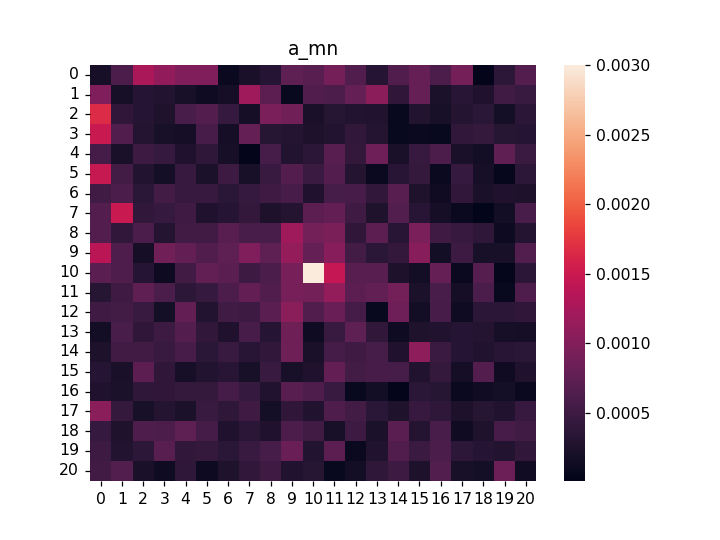

Text(0.5, 1.0, 'a_mn')

In [51]:
import seaborn as sns
fig=plt.figure()
sns.heatmap(np.abs(c[0][:(2*M+1)**2].reshape((2*M+1, 2*M+1))))
plt.title("a_mn")

<IPython.core.display.Javascript object>


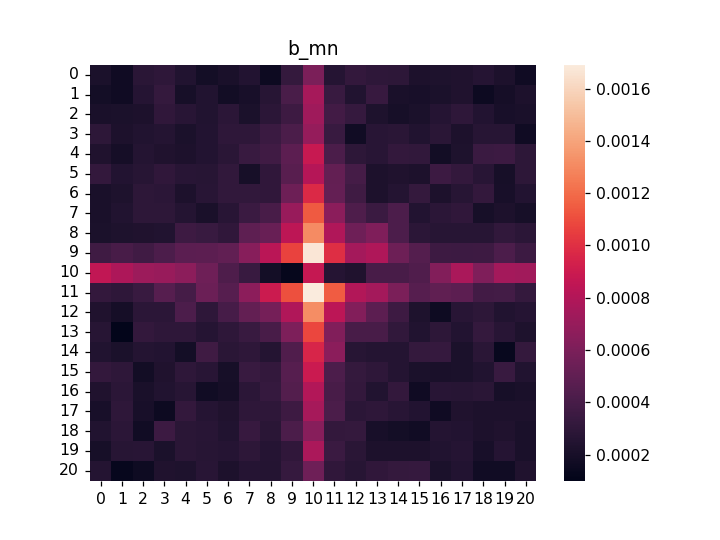

Text(0.5, 1.0, 'b_mn')

In [52]:
fig=plt.figure()
sns.heatmap(np.abs(c[0][(2*M+1)**2:].reshape((2*M+1, 2*M+1))))
plt.title("b_mn")

<IPython.core.display.Javascript object>


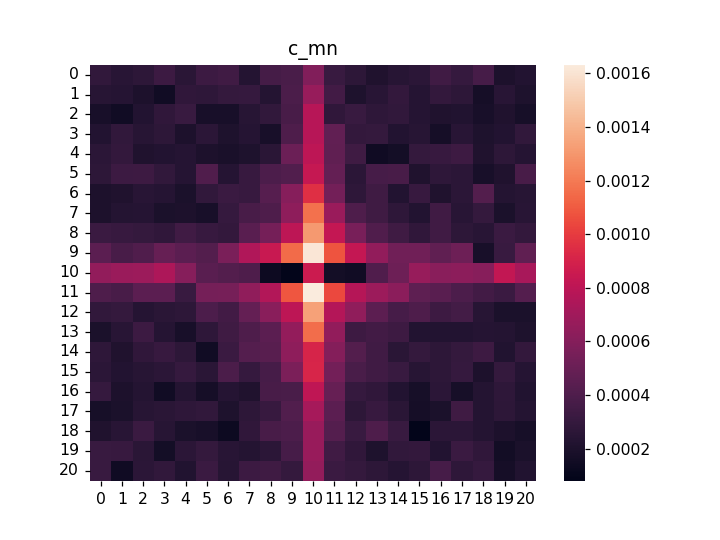

Text(0.5, 1.0, 'c_mn')

In [53]:
fig=plt.figure()
sns.heatmap(np.abs(c[1][:(2*M+1)**2].reshape((2*M+1, 2*M+1))))
plt.title("c_mn")

<IPython.core.display.Javascript object>


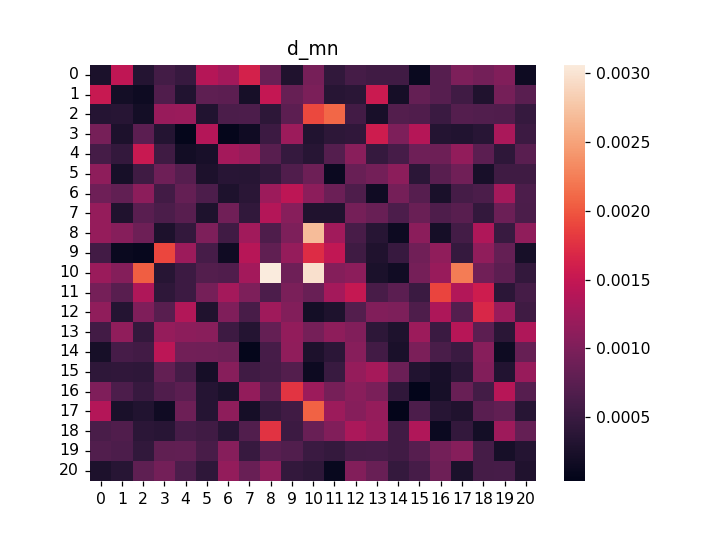

Text(0.5, 1.0, 'd_mn')

In [56]:
fig=plt.figure()
sns.heatmap(np.abs(c[1][(2*M+1)**2:].reshape((2*M+1, 2*M+1))))
plt.title("d_mn")

In [51]:
rx_iq_opt0 = V[0]@c[0]

In [52]:
d[:, 0]@d[:, 0].conj()

(83310.86+0j)

In [53]:
(d[:, 0]-rx_iq_opt0)@(d[:, 0]-rx_iq_opt0).conj()

(1289732+0j)

In [69]:
rx_iq_opt0[:10]

array([ 0.30609834+0.08556688j,  0.4371792 -0.39704442j,
       -0.16438985+0.02461433j,  0.19591498+0.04168069j,
       -0.07774115+0.04658374j, -0.78009033-0.30128384j,
       -0.20414805-0.00870681j, -0.5178461 -0.06842554j,
       -0.4319005 -0.05529994j,  0.30507648-0.1999731j ], dtype=complex64)

In [70]:
d[:10,0]

array([ 0.53275883+0.7239331j , -0.08579838+0.2850914j ,
        0.29250252-0.03691322j,  0.03943706+0.03685522j,
       -0.352722  -0.8853512j ,  0.19921064-0.3770976j ,
        0.05248117+0.5116837j , -0.2243371 +0.27611804j,
       -0.8426294 +0.22806263j,  0.37673044+0.12459922j], dtype=complex64)

In [60]:
print("NMSE: {} dB".format(utility.nmse_db(rx_iq[V_range, 0] - rx_iq_opt0, tx_iq[V_range, 0])))

NMSE: -3.4410121932773796 dB
